## 1. Introduction:

This notebook is a tutorial to the multi-modal architecture LaTr (mainly for the purpose of Scene Text VQA).
We would take in, the train-images of the TextVQA Dataset, and then would train the model (taking as near arguments for training as possible)
We would also be logging the metrics with the help of Weights and Biases

## A small Introduction about the Model:

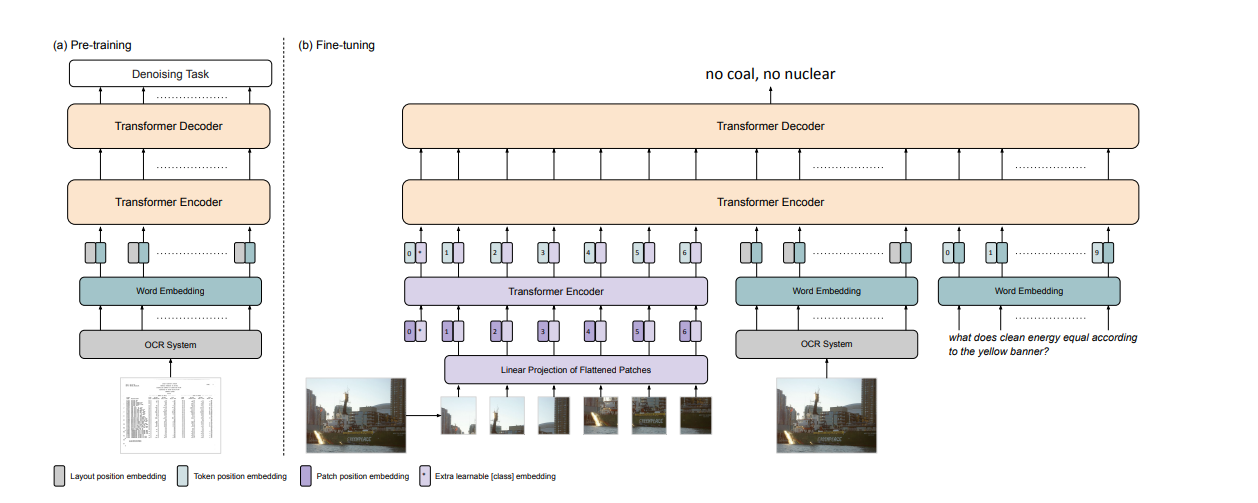

LaTr: Layout-aware transformer for scene-text VQA is a novel multimodal architecture for Scene Text Visual Question Answering (STVQA).

LaTr improves robustness towards OCR errors, a common reason for failure cases in STVQA. In addition, by leveraging a vision transformer, LaTr eliminate the need for an external object detector. LaTr outperforms state-of-the-art STVQA methods on multiple datasets. In particular, +7.6% on TextVQA, +10.8% on ST-VQA and +4.0% on OCR-VQA (all absolute accuracy numbers).

For more understanding of the model and its code implementation, one can visit [here](https://github.com/uakarsh/latr). So, let us go on to see what this model has to offer

<!-- The report for this entire run is attached [here](https://wandb.ai/iakarshu/RVL%20CDIP%20with%20DocFormer%20New%20Version/reports/Performance-of-DocFormer-with-RVL-CDIP-Test-Dataset--VmlldzoyMTI3NTM4)

<img src = "https://drive.google.com/u/1/uc?id=1IOyYXbU8bi5FDq59Z4RI1Qkoc54CzZto&export=download" > -->

<!-- 
### An Interactive Demo for the same can be found on 🤗 space [here](https://huggingface.co/spaces/iakarshu/docformer_for_document_classification) -->

### Downloading and Unzipping the Data 📘:

In [ ]:
!wget https://dl.fbaipublicfiles.com/textvqa/images/train_val_images.zip
!wget https://dl.fbaipublicfiles.com/textvqa/data/TextVQA_0.5.1_train.json
!wget https://dl.fbaipublicfiles.com/textvqa/data/TextVQA_Rosetta_OCR_v0.2_train.json
    
!wget https://dl.fbaipublicfiles.com/textvqa/data/TextVQA_0.5.1_val.json
!wget https://dl.fbaipublicfiles.com/textvqa/data/TextVQA_Rosetta_OCR_v0.2_val.json

In [ ]:
!unzip './train_val_images.zip'

## 2. Downloading and Installing the Libraries ⚙️:

In [ ]:
# ! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
## Downloading the requirements
!pip install -q sentencepiece==0.1.91
!pip install -q 'Pillow==7.1.2'
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -U pytorch_warmup

In [ ]:
!git clone https://github.com/uakarsh/latr.git
import sys
sys.path.append('./latr/src/latr/')

In [ ]:
## Logging into wandb

import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")
wandb.login(key=secret_value_0)

## 3. Some important Library imports 🛳️

In [ ]:
## Default Library import

import os
import json
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import json

## For the purpose of displaying the progress of map function
tqdm.pandas()

## Visualization libraries
import pytesseract
from PIL import Image, ImageDraw

## Specific libraries of LaTr
import torch.nn as nn
from dataset import load_json_file, get_specific_file, resize_align_bbox, get_tokens_with_boxes, create_features
from modeling import LaTr_for_pretraining, LaTr_for_finetuning
from utils import convert_ans_to_token, convert_ques_to_token, rotate, convert_token_to_ques, convert_token_to_answer

## Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Warm-up
import pytorch_warmup as warmup

import pytorch_lightning as pl

In [ ]:
## Setting the hyperparameters as well as primary configurations

PAD_TOKEN_BOX = [0, 0, 0, 0]
max_seq_len = 512
batch_size = 2
target_size = (500,384) ## Note that, ViT would make it 224x224 so :(
t5_model = "t5-base"

In [ ]:
## Appending the ocr and json path

base_path = './'
train_ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_train.json')
train_json_path = os.path.join(base_path, 'TextVQA_0.5.1_train.json')

val_ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_val.json')
val_json_path = os.path.join(base_path, 'TextVQA_0.5.1_val.json')

In [ ]:
## Loading the files

train_ocr_json = json.load(open(train_ocr_json_path))['data']
train_json = json.load(open(train_json_path))['data']

val_ocr_json = json.load(open(val_ocr_json_path))['data']
val_json = json.load(open(val_json_path))['data']

In [ ]:
## Useful for the key-value extraction

train_json_df = pd.DataFrame(train_json)
train_ocr_json_df = pd.DataFrame(train_ocr_json)

val_json_df = pd.DataFrame(val_json)
val_ocr_json_df = pd.DataFrame(val_ocr_json)

In [ ]:
## Converting list to string

train_json_df['answers'] = train_json_df['answers'].apply(lambda x: " ".join(list(map(str, x))))
val_json_df['answers']   = val_json_df['answers'].apply(lambda x: " ".join(list(map(str, x))))

In [ ]:
## Dropping of the images which doesn't exist, might take some time

base_img_path = os.path.join('./', 'train_images')
train_json_df['path_exists'] = train_json_df['image_id'].progress_apply(lambda x: os.path.exists(os.path.join(base_img_path, x)+'.jpg'))
train_json_df = train_json_df[train_json_df['path_exists']==True]

val_json_df['path_exists'] = val_json_df['image_id'].progress_apply(lambda x: os.path.exists(os.path.join(base_img_path, x)+'.jpg'))
val_json_df = val_json_df[val_json_df['path_exists']==True]

In [ ]:
## Dropping the unused columns

train_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens', 'path_exists'
                              ], axis = 1, inplace = True)
val_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens', 'path_exists'
                              ], axis = 1, inplace = True)

In [ ]:
## Deleting the json

del train_json
del train_ocr_json
del val_json
del val_ocr_json

In [ ]:
## Grouping for the purpose of feature extraction
grouped_df = train_json_df.groupby('image_id')

## Getting all the unique keys of the group by object
keys = list(grouped_df.groups.keys())

In [ ]:
## Tokenizer import

from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained(t5_model)

## 4. Making the dataset 💽:
The main idea behind making the dataset is, to pre-process the input into a given format, and then provide the input to the model. So, simply just the image path, and the other configurations, and boom 💥, you would get the desired pre-processed input

In [ ]:
# sent = tokenizer.encode("what is the url in the picture?", max_length = 512, truncation = True, padding = 'max_length', return_tensors = 'pt')[0]
# dec_sent = tokenizer.decode(sent, skip_special_tokens = True)
# dec_sent

In [ ]:
## Defining the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class TextVQA(Dataset):
  def __init__(self, base_img_path, json_df, ocr_json_df, tokenizer, transform = None, max_seq_length = 512, target_size = (500,384), fine_tune = True):

    self.base_img_path = base_img_path
    self.json_df = json_df
    self.ocr_json_df = ocr_json_df
    self.tokenizer = tokenizer
    self.target_size = target_size
    self.transform = transform
    self.max_seq_length = max_seq_length
    self.fine_tune = fine_tune

  def __len__(self):
    return len(self.json_df)

  def __getitem__(self, idx):

    curr_img = self.json_df.iloc[idx]['image_id']
    ocr_token = self.ocr_json_df[self.ocr_json_df['image_id']==curr_img]['ocr_info'].values.tolist()[0]

    boxes = []
    words = []

    current_group = self.json_df.iloc[idx]
    width, height = current_group['image_width'], current_group['image_height']

    ## Getting the ocr and the corresponding bounding boxes
    for entry in ocr_token:
      xmin, ymin, w, h, angle = entry['bounding_box']['top_left_x'], entry['bounding_box']['top_left_y'],  entry['bounding_box']['width'],  entry['bounding_box']['height'], entry['bounding_box']['rotation']
      xmin, ymin,w, h = resize_align_bbox([xmin, ymin, w, h], 1, 1, width, height)
      
      x_centre = xmin + (w/2)
      y_centre = ymin + (h/2)

      ## print("The angle is:", angle)
      xmin, ymin = rotate([x_centre, y_centre], [xmin, ymin], angle)

      xmax = xmin + w
      ymax = ymin + h

      ## Bounding boxes are normalized
      curr_bbox = [xmin, ymin, xmax, ymax]
      boxes.append(curr_bbox)
      words.append(entry['word'])

    img_path = os.path.join(self.base_img_path, curr_img)+'.jpg'  ## Adding .jpg at end of the image, as the grouped key does not have the extension format 

    assert os.path.exists(img_path)==True, f'Make sure that the image exists at {img_path}!!'
    ## Extracting the feature
    
    if self.fine_tune:
        
        ## For fine-tune stage, they use [0, 0, 1000, 1000] for all the bounding box
        img = Image.open(img_path).convert("RGB")
        img = img.resize(self.target_size)
        boxes = torch.zeros(self.max_seq_length, 4)
        boxes[:, 2] = 1000
        boxes[:, 3] = 1000
        
        words = " ".join(words)
        tokenized_words = self.tokenizer.encode(words, max_length = self.max_seq_length, truncation = True, padding = 'max_length', return_tensors = 'pt')[0]
        
    else:
        ## For pre-train, this strategy would be useful
        img, boxes, tokenized_words = create_features(image_path = img_path,
                                                      tokenizer = self.tokenizer,
                                                      target_size = self.target_size,
                                                      max_seq_length = self.max_seq_length,
                                                      use_ocr = False,
                                                      bounding_box = boxes,
                                                      words = words
                                                      )
    
    ## Converting the boxes as per the format required for model input
    boxes = torch.as_tensor(boxes, dtype=torch.int32)
    width = (boxes[:, 2] - boxes[:, 0]).view(-1, 1)
    height = (boxes[:, 3] - boxes[:, 1]).view(-1, 1)
    boxes = torch.cat([boxes, width, height], axis = -1)

    ## Clamping the value,as some of the box values are out of bound
    boxes[:, 0] = torch.clamp(boxes[:, 0], min = 0, max = 1000)
    boxes[:, 2] = torch.clamp(boxes[:, 2], min = 0, max = 1000)
    boxes[:, 4] = torch.clamp(boxes[:, 4], min = 0, max = 1000)
    
    boxes[:, 1] = torch.clamp(boxes[:, 1], min = 0, max = 1000)
    boxes[:, 3] = torch.clamp(boxes[:, 3], min = 0, max = 1000)
    boxes[:, 5] = torch.clamp(boxes[:, 5], min = 0, max = 1000)
    
    ## Tensor tokenized words
    tokenized_words = torch.as_tensor(tokenized_words, dtype=torch.int32)

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)


    ## Getting the Question
    question = current_group['question']   
    question = convert_ques_to_token(question = question, tokenizer = self.tokenizer)

    ## Getting the Answer
    answer = current_group['answers']
    answer = convert_ques_to_token(question = answer, tokenizer = self.tokenizer).long()

    return {'img':img, 'boxes': boxes, 'tokenized_words': tokenized_words, 'question': question, 'answer': answer, 'id': torch.as_tensor(idx)}

In [ ]:
train_ds = TextVQA(base_img_path = base_img_path,
                   json_df = train_json_df,
                   ocr_json_df = train_ocr_json_df,
                   tokenizer = tokenizer,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   target_size = target_size
                   )


val_ds = TextVQA(base_img_path = base_img_path,
                   json_df = val_json_df,
                   ocr_json_df = val_ocr_json_df,
                   tokenizer = tokenizer,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   target_size = target_size
                   )

In [ ]:
idx = 1569

In [ ]:
encoding = train_ds[idx]  ## Might take time as per the processing
for key in list(encoding.keys()):
  print_statement = '{0: <30}'.format(str(key) + " has a shape:")
  print(print_statement, encoding[key].shape)

In [ ]:
## Sample Img, Sample box, sample words, sample answer, sample question

s_img = encoding['img']
s_boxes = encoding['boxes']
s_words = encoding['tokenized_words']
s_ans = encoding['answer']
s_ques = encoding['question']

## Decoding the Question, Answer as well as the Image for the post-processing

### 1. Image Part

In [ ]:
## OCR and Image part
actual_img = transforms.ToPILImage()(s_img).convert("RGB")
actual_boxes = s_boxes[:, :4].numpy().tolist()  ## (xmin, ymin, xmax, ymax)

In [ ]:
## If use fine_tune = False, we can get the ocr as well

# from PIL import Image, ImageDraw

# # create rectangle image
# draw_on_img = ImageDraw.Draw(actual_img)  

# for box in actual_boxes:
#     draw_on_img.rectangle(box, outline ="red")


In [ ]:
actual_img

### 2. Question Part

In [ ]:
decoded_ques = convert_token_to_ques(s_ques, tokenizer)
print(decoded_ques)  ## Goes well!!

### 3. Answer Part

In [ ]:
decoded_answer = convert_token_to_ques(s_ans, tokenizer)
print(decoded_answer)  ## Goes Well!!

## 4.2. Making the Collate function for DataLoader:

More on collate function can be known from [here](https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
vit_feat_extract = ViTFeatureExtractor("google/vit-base-patch16-224-in21k")

In [ ]:
def collate_fn(data_bunch):

  '''
  A function for the dataloader to return a batch dict of given keys

  data_bunch: List of dictionary
  '''

  dict_data_bunch = {}

  for i in data_bunch:
    for (key, value) in i.items():
      if key not in dict_data_bunch:
        dict_data_bunch[key] = []
      dict_data_bunch[key].append(value)

  for key in list(dict_data_bunch.keys()):
      dict_data_bunch[key] = torch.stack(dict_data_bunch[key], axis = 0)

  if 'img' in dict_data_bunch:
    ## Pre-processing for ViT
    dict_data_bunch['img'] = vit_feat_extract(list(dict_data_bunch['img']),return_tensors = 'pt')['pixel_values']

  return dict_data_bunch

## 5. Defining the DataModule 📖

* A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data:

* A DataModule is simply a collection of a train_dataloader(s), val_dataloader(s), test_dataloader(s) and predict_dataloader(s) along with the matching transforms and data processing/downloads steps required.




In [ ]:
class DataModule(pl.LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  batch_size = 1):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size

    
  ## The parameters for Dataloader have been taken from here: https://docs.mosaicml.com/en/v0.7.1/trainer/dataloaders.html#passing-a-pytorch-dataloader
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, 
                      collate_fn = collate_fn, shuffle = True, num_workers = 2, pin_memory = True, persistent_workers = True)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size,
                    collate_fn = collate_fn, shuffle = False, num_workers = 2, pin_memory = True, persistent_workers = True)

## 6. Modeling Part 🏎️
1. Firstly, we would define the pytorch model with our configurations
2. Secondly, we would encode it in the PyTorch Lightening module, and boom 💥 our work of defining the model is done

In [ ]:
## keys are img, boxes, tokenized_words, answer, question

In [ ]:
config = {
    't5_model': 't5-base',
    'vocab_size': 32128,
    'hidden_state': 768,
    'max_2d_position_embeddings': 1001,
    'classes': 32128,  ## number of tokens
    'seq_len': 512
}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# finetuned_latr = LaTr_for_finetuning(config).to(device)
# datamodule = DataModule(train_ds, val_ds)

In [ ]:
from sklearn.metrics import accuracy_score
def calculate_acc_score(pred, gt):
    
    ## Function ignores the calculation of padding part
    ## Shape (seq_len, seq_len)
    mask = torch.clamp(gt, min = 0, max = 1)
    last_non_zero_argument = (mask != 0).nonzero()[1][-1]
    pred = pred[:last_non_zero_argument]
    gt = gt[:last_non_zero_argument]  ## Include all the arguments till the first padding index
    
    return accuracy_score(pred, gt)

In [ ]:
## https://stackoverflow.com/questions/69899602/linear-decay-as-learning-rate-scheduler-pytorch
def polynomial(base_lr, iter, max_iter = 1e5, power = 1):
    return base_lr * ((1 - float(iter) / max_iter) ** power)

class LaTrForVQA(pl.LightningModule):
  def __init__(self, config , learning_rate = 1e-4, max_steps = 100000//2):
    super(LaTrForVQA, self).__init__()
    
    self.config = config
    self.save_hyperparameters()
    self.latr =  LaTr_for_finetuning(config)
    self.training_losses = []
    self.validation_losses = []
    self.max_steps = max_steps

#   def configure_optimizers(self):
#     optimizer = torch.optim.AdamW(self.parameters(), lr = self.hparams['learning_rate'])
#     warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period = 1000)  
#     scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,total_iters  = self.max_steps,  verbose = True)
#     return [optimizer], [{"scheduler": (lr_scheduler, warmup_scheduler), "interval": "step"}]

#   def lr_scheduler_step(self, scheduler, optimizer_idx, metric):
#         lr_scheduler, warmup_scheduler = scheduler
#         with warmup_scheduler.dampening():
#                 lr_scheduler.step()

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr = self.hparams['learning_rate'])


  def forward(self, batch_dict):
    boxes =   batch_dict['boxes']
    img =     batch_dict['img']
    question = batch_dict['question']
    words =   batch_dict['tokenized_words']
    answer_vector = self.latr(lang_vect = words, 
                               spatial_vect = boxes, 
                               img_vect = img, 
                               quest_vect = question
                               )
    return answer_vector

  def calculate_metrics(self, prediction, labels):

      ## Calculate the accuracy score between the prediction and ground label for a batch, with considering the pad sequence
      batch_size = len(prediction)
      ac_score = 0

      for (pred, gt) in zip(prediction, labels):
        ac_score+= calculate_acc_score(pred.detach().cpu(), gt.detach().cpu())
      ac_score = ac_score/batch_size
      return ac_score

  def training_step(self, batch, batch_idx):
    answer_vector = self.forward(batch)

    ## https://discuss.huggingface.co/t/bertformaskedlm-s-loss-and-scores-how-the-loss-is-computed/607/2
    loss = nn.CrossEntropyLoss()(answer_vector.reshape(-1,self.config['classes']), batch['answer'].reshape(-1))
    _, preds = torch.max(answer_vector, dim = -1)

    ## Calculating the accuracy score
    train_acc = self.calculate_metrics(preds, batch['answer'])
    train_acc = torch.tensor(train_acc)

    ## Logging
    self.log('train_ce_loss', loss,prog_bar = True)
    self.log('train_acc', train_acc, prog_bar = True)
    self.training_losses.append(loss.item())

    return loss

  def validation_step(self, batch, batch_idx):
    logits = self.forward(batch)
    loss = nn.CrossEntropyLoss()(logits.reshape(-1,self.config['classes']), batch['answer'].reshape(-1))
    _, preds = torch.max(logits, dim = -1)

    ## Validation Accuracy
    val_acc = self.calculate_metrics(preds.cpu(), batch['answer'].cpu())
    val_acc = torch.tensor(val_acc)

    ## Logging
    self.log('val_ce_loss', loss, prog_bar = True)
    self.log('val_acc', val_acc, prog_bar = True)
    
    return {'val_loss': loss, 'val_acc': val_acc}
  ## For the fine-tuning stage, Warm-up period is set to 1,000 steps and again is linearly decayed to zero, pg. 12, of the paper
  ## Refer here: https://github.com/Lightning-AI/lightning/issues/328#issuecomment-550114178
  
  def optimizer_step(self, epoch_nb, batch_nb, optimizer, optimizer_i, opt_closure = None, on_tpu=False,
    using_native_amp=False, using_lbfgs=False):

        ## Warmup for 1000 steps
        if self.trainer.global_step < 1000:
            lr_scale = min(1., float(self.trainer.global_step + 1) / 1000.)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.hparams.learning_rate

        ## Linear Decay
        else:
            for pg in optimizer.param_groups:
                pg['lr'] = polynomial(self.hparams.learning_rate, self.trainer.global_step, max_iter = self.max_steps)

        optimizer.step(opt_closure)
        optimizer.zero_grad()

  def validation_epoch_end(self, outputs):
        
        
        val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        self.log('val_loss_epoch_end', val_loss, on_epoch=True, sync_dist=True)
        self.log('val_acc_epoch_end', val_acc, on_epoch=True, sync_dist=True)
        
        self.val_prediction = []
        
#   def training_epoch_end(self, training_step_outputs):
#     train_loss_mean = np.mean(self.training_losses)
#     self.logger.experiment.add_scalar('training_loss', train_loss_mean, global_step=self.current_epoch)
#     self.training_losses = []  # reset for next epoch

#   def validation_epoch_end(self, validation_step_outputs):
#     val_loss_mean = np.mean(self.training_losses)
#     self.logger.experiment.add_scalar('validation_loss', val_loss_mean, global_step=self.current_epoch)
#     self.validation_losses = []  # reset for next epoch

In [ ]:
url_for_ckpt = 'https://www.kaggleusercontent.com/kf/99663112/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..GfuZWkqwWi9nROCTnAS3OQ.YowTb3CNlES2WS_F6BvOSrGs3uLWc2kSBkhElYUcndML0Feuiizdu8trA2e4aj_kdluv1nYlVpS3_86VaJfgSBtyJShQoB0CyxCqdvdMiKl4eQQdWUv2XrTBecEJPXupdFaElzr57CcRjpz35rueyDjf3GVJLznkpSdoyWwSxoxCACbUpS73PKWi97WHfPmEWQgXTDxT_Uno_Pau6fayKyzJ-vWrETzOA2Z6f1-i7umK48D7JBQacS2g_40dW8wIH34QsztCZhHOake7qZnXU_19qaFeDQCNldZ4HcGAmKMtqYI_NK_By370IZ6OHe5Q-mh1f_9SaZoXCzzgaNx4Wsw1THZgzSjZgP2dTLP6a4ZkjHFWiZdkl0azvmoCmSVVYbRdQ9_iI9sFvhUpDWj1bOlr-Zrq9gRi8ksaH9rIzrzk63x_fKPGphZKpxB_l_6iewdGt4yb3GB8kWyGrxBnsGvV5Ei7gTaqv9OAkSKTACMEKB-rj-T8HKtk3ktnEqGMCpHTpkB8RYE6EqYRPbnSYMShjZb12GSn5uYntLtcG7MUbQX-OMt0vzh9fag_zpCyO89K56jxZ6Q9kWdADG0C2T0nR8uC8vWUUBptWNc2tt6pcupcUO19kt7ddNHMbxajHym5AijizrfJbkqnujEodlHWc8C77PawpX2xUPvIlbSvhbdsRRyYfOFGLmZsDdKa.c9dgiKXE5w_-qo4J3He6Qw/models/epoch=0-step=34602.ckpt'

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

def main():
    datamodule = DataModule(train_ds, val_ds)
    max_steps = 50000       ## 60K Steps
    latr = LaTrForVQA(config, max_steps= max_steps)
    
    try:
        latr = latr.load_from_checkpoint(url_for_ckpt)
        print("Checkpoint loaded correctly")
    except:
        print("Could not load checkpoint")
        return 
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="./models", monitor="val_ce_loss", mode="min"
    )
    
    wandb.init(config=config, project="VQA with LaTr")
    wandb_logger = WandbLogger(project="VQA with LaTr", log_model = True, entity="iakarshu")
    
    ## https://www.tutorialexample.com/implement-reproducibility-in-pytorch-lightning-pytorch-lightning-tutorial/
    pl.seed_everything(42, workers=True)
    
    trainer = pl.Trainer(
        max_steps = max_steps,
        default_root_dir="logs",
        gpus=(1 if torch.cuda.is_available() else 0),
#         accelerator="tpu",
#         devices=8,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
        deterministic=True
    )
    
    trainer.fit(latr, datamodule)

In [ ]:
# sample = LaTr_for_finetuning(config).to(device)

In [ ]:
## Debug

# for batch in tqdm(DataModule(train_ds, val_ds).train_dataloader(), total = len(DataModule(train_ds, val_ds).train_dataloader())):
#     try:
#         out = sample.pre_training_model.top_left_y(batch['boxes'][:, :, 1])
#         out = sample.pre_training_model.top_left_x(batch['boxes'][:, :, 0])
#         out = sample.pre_training_model.bottom_right_x(batch['boxes'][:, :, 2])
#         out = sample.pre_training_model.bottom_right_y(batch['boxes'][:, :, 3])
#         out = sample.pre_training_model.width_emb(batch['boxes'][:, :, 4])
#         out = sample.pre_training_model.height_emb(batch['boxes'][:, :, 5])
#     except:
#         print("Problem found....")
#         break

In [ ]:
if __name__ == "__main__":
    main()

## References:

1. [MLOps Repo](https://github.com/graviraja/MLOps-Basics) (For the integration of model and data with PyTorch Lightening) 
2. [PyTorch Lightening Docs](https://pytorch-lightning.readthedocs.io/en/stable/index.html) For all the doubts and bugs
3. [My Repo](https://github.com/uakarsh/latr) For downloading the model and pre-processing steps
4. Google for other stuffs